# Analyze Model Behvaiour of 2D Segmentation

Consider to download this Jupyter Notebook and run locally, or test it with Colab.
<br>
[![Download](https://img.shields.io/badge/Download-jupyter-blue)](https://github.com/ZerojumpLine/MOVAL/blob/main/docs/source/demos/analysis_seg2d.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1cpEfZYbyYrtPByvf1-foPZ4ul8KVuAc1)

* In this notebook, we will show how to analyze the model behaviour based using MOVAL for multi-class 2D segmentation tasks.
<br>
* More specifically, we show an example of analyzing model behaviour under domain shifts on Cardiac MRI segmentation (into 4 classes including background, left ventricle (LV), myocardium(MYO) and right ventricle (RV)) based on a 3D U-Net. We will utilize the calculated logits on test dataset acquired with a different scanner.
<br>
* We will visualize the calibrated confidence scores as an proper indication of missegmentation.

In [3]:
!pip install moval
!pip install seaborn
!pip install pandas
!pip install tqdm
!pip install matplotlib
!pip install nibabel

In [4]:
import os
import gdown
import itertools
import zipfile
import pandas as pd
import numpy as np
import nibabel as nib
import moval
from moval.solvers.utils import ComputMetric
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
print(f"The installed MOVAL verision is {moval.__version__}")

The installed MOVAL verision is 0.1.16


## Load the data

In [6]:
# download the data of cardiac

output = "data_moval_supp.zip"
if not os.path.exists(output):
    url = "https://drive.google.com/u/0/uc?id=1ZlC66MGmPlf05aYYCKBaRT2q5uod8GFk&export=download"
    output = "data_moval_supp.zip"
    gdown.download(url, output, quiet=False)

directory_data = "data_moval_supp"
if not os.path.exists(directory_data):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(directory_data)

In [7]:
# download the coresponding image data

output = "img_cardiac.zip"
if not os.path.exists(output):
    url = "https://drive.google.com/u/0/uc?id=1kS5V69dfdPEGiMfauMLuhi76Vrb8VB5k&export=download"
    output = "img_cardiac.zip"
    gdown.download(url, output, quiet=False)

directory_data = "img_cardiac"
if not os.path.exists(directory_data):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(directory_data)

In [8]:
ls

analysis_cls.ipynb    data_moval_supp.zip   img_cifar/
analysis_seg2d.ipynb  estim_cls.ipynb       img_cifar.zip
analysis_seg3d.ipynb  estim_seg2d.ipynb     img_prostate/
data_moval/           estim_seg3d.ipynb     img_prostate.zip
data_moval.zip        img_cardiac/
data_moval_supp/      img_cardiac.zip


In [9]:
# now I am playing with cardiac segmentation

Datafile_eval = "data_moval_supp/Cardiacresults/seg-eval.txt"
Imglist_eval = open(Datafile_eval)
Imglist_eval_read = Imglist_eval.read().splitlines()

logits = []
gt = []
for Imgname_eval in Imglist_eval_read:
    #
    caseID = Imgname_eval.split("/")[-2]
    #
    GT_file = f"data_moval_supp/Cardiacresults/GT/1/{caseID}/seg.nii.gz"
    #
    logit_cls0_file = "data_moval_supp/Cardiacresults/cardiacval/results/pred_" + caseID + "cls0_prob.nii.gz"
    logit_cls1_file = "data_moval_supp/Cardiacresults/cardiacval/results/pred_" + caseID + "cls1_prob.nii.gz"
    logit_cls2_file = "data_moval_supp/Cardiacresults/cardiacval/results/pred_" + caseID + "cls2_prob.nii.gz"
    logit_cls3_file = "data_moval_supp/Cardiacresults/cardiacval/results/pred_" + caseID + "cls3_prob.nii.gz"
    #
    logit_cls0_read = nib.load(logit_cls0_file)
    logit_cls1_read = nib.load(logit_cls1_file)
    logit_cls2_read = nib.load(logit_cls2_file)
    logit_cls3_read = nib.load(logit_cls3_file)
    #
    logit_cls0      = logit_cls0_read.get_fdata()   # ``(H, W, D)``
    logit_cls1      = logit_cls1_read.get_fdata()
    logit_cls2      = logit_cls2_read.get_fdata()
    logit_cls3      = logit_cls3_read.get_fdata()
    #
    GT_read         = nib.load(GT_file)
    GTimg           = GT_read.get_fdata()           # ``(H, W, D)``
    #
    logit_cls = np.stack((logit_cls0, logit_cls1, logit_cls2, logit_cls3))  # ``(d, H, W, D)``
    # only including the slices that contains labels
    for dslice in range(GTimg.shape[2]):
        if np.sum(GTimg[:, :, dslice]) > 0:
            logits.append(logit_cls[:, :, :, dslice])
            gt.append(GTimg[:, :, dslice])

# logits is a list of length ``n``,  each element has ``(d, H, W)``. 
# gt is a list of length ``n``,  each element has ``(H, W)``.
# H and W could differ for different cases.

caseIDs = ['A5D0G0_0', 'B0N3W8_15', 'E5S7W7_12', 'H7N4V9_0', 'I0I2J8_7']

logits_test = []
gt_test = []
imgs_test = []
for caseID in caseIDs:
    GT_file = f"data_moval_supp/Cardiacresults/GT/2/{caseID}/seg.nii.gz"
    #
    logit_cls0_file = "data_moval_supp/Cardiacresults/cardiactest_2/results/pred_" + caseID + "cls0_prob.nii.gz"
    logit_cls1_file = "data_moval_supp/Cardiacresults/cardiactest_2/results/pred_" + caseID + "cls1_prob.nii.gz"
    logit_cls2_file = "data_moval_supp/Cardiacresults/cardiactest_2/results/pred_" + caseID + "cls2_prob.nii.gz"
    logit_cls3_file = "data_moval_supp/Cardiacresults/cardiactest_2/results/pred_" + caseID + "cls3_prob.nii.gz"
    #
    logit_cls0_read = nib.load(logit_cls0_file)
    logit_cls1_read = nib.load(logit_cls1_file)
    logit_cls2_read = nib.load(logit_cls2_file)
    logit_cls3_read = nib.load(logit_cls3_file)
    #
    logit_cls0      = logit_cls0_read.get_fdata()   # ``(H, W, D)``
    logit_cls1      = logit_cls1_read.get_fdata()
    logit_cls2      = logit_cls2_read.get_fdata()
    logit_cls3      = logit_cls3_read.get_fdata()
    #
    img_file = f"img_cardiac/img_cardiac/2/{caseID}/image.nii.gz"
    img_read = nib.load(img_file)
    img_data      = img_read.get_fdata()   # ``(H, W, D)``
    #
    GT_read         = nib.load(GT_file)
    GTimg           = GT_read.get_fdata()           # ``(H, W, D)``
    logit_cls = np.stack((logit_cls0, logit_cls1, logit_cls2, logit_cls3))  # ``(d, H, W, D)``
    # only including the slices that contains labels
    for dslice in range(GTimg.shape[2]):
        if np.sum(GTimg[:, :, dslice]) > 0:
            logits_test.append(logit_cls[:, :, :, dslice])
            gt_test.append(GTimg[:, :, dslice])
            imgs_test.append(img_data[:, :, dslice])

# logits_test is a list of length ``n``,  each element has ``(d, H, W)``. 
# gt_test is a list of length ``n``,  each element has ``(H, W)``.
# H and W could differ for different cases.

In [10]:
print(f"The validation predictions, ``logits`` are a list of length {len(logits)} each element has approximately {logits[0].shape}")
print(f"The validation labels, ``gt`` are a list of length {len(gt)}, each element has approximately {gt[0].shape}\n")
print(f"The test predictions, ``logits_test`` are a list of length {len(logits_test)} each element has approximately {logits_test[0].shape}")
print(f"The test labels, ``gt_test`` are a list of length {len(gt_test)}, each element has approximately {gt_test[0].shape}")
print(f"The test imgs, ``imgs_test`` are a list of length {len(imgs_test)}, each element has approximately {imgs_test[0].shape}")

The validation predictions, ``logits`` are a list of length 156 each element has approximately (4, 210, 257)
The validation labels, ``gt`` are a list of length 156, each element has approximately (210, 257)

The test predictions, ``logits_test`` are a list of length 38 each element has approximately (4, 338, 338)
The test labels, ``gt_test`` are a list of length 38, each element has approximately (338, 338)
The test imgs, ``imgs_test`` are a list of length 38, each element has approximately (338, 338)


In [11]:
import random
random.seed(79)
test_inds = list(range(len(logits)))
random.shuffle(test_inds)
test_inds = test_inds[:100]
#
_logits = []
_gt = []
for test_ind in test_inds:
    _logits.append(logits[test_ind])
    _gt.append(gt[test_ind])
logits_val = _logits
gt_val = _gt
#
print(f"The validation predictions, ``logits`` are a list of length {len(logits_val)} each element has approximately {logits_val[0].shape}")
print(f"The validation labels, ``gt`` are a list of length {len(gt_val)}, each element has approximately {gt_val[0].shape}")

The validation predictions, ``logits`` are a list of length 100 each element has approximately (4, 223, 272)
The validation labels, ``gt`` are a list of length 100, each element has approximately (223, 272)


## MOVAL estimataion

In [12]:
moval_options = []
moval_options.append(['ac-model', 'segmentation', 'max_class_probability-conf', False])
moval_options.append(['ts-model', 'segmentation', 'max_class_probability-conf', False])
moval_options.append(['ts-model', 'segmentation', 'max_class_probability-conf', True])
moval_options.append(['ts-atc-model', 'segmentation', 'entropy-conf', True])

In [13]:
def test_cls(estim_algorithm, mode, confidence_scores, class_specific, logits, gt, logits_tests, gt_tests):
    """Test MOVAL with different conditions for segmentation tasks
        
    Args:
        mode (str): The given task to estimate model performance.
        confidence_scores (str):
            The method to calculate the confidence scores. We provide a list of confidence score calculation methods which 
            can be displayed by running :py:func:`moval.models.get_conf_options`.
        estim_algorithm (str):
            The algorithm to estimate model performance. We also provide a list of estimation algorithm which can be displayed by
            running :py:func:`moval.models.get_estim_options`.
        class_specific (bool):
            If ``True``, the calculation will match class-wise confidence to class-wise accuracy.
        logits: The network output (logits) of a list of n ``(d, H, W, (D))`` for segmentation. 
        gt: The cooresponding annotation of a list of n ``(H, W, (D))`` for segmentation.
        logits_tests:  The network testing output (logits) of a list of n' ``(d, H', W', (D'))`` for segmentation. 
        gt_test: The cooresponding testing annotation of a list of n' ``(H', W', (D'))`` for segmentation.

    Returns:
        err_test (float): testing error.
        moval_model: Optimized moval model.

    """
    
    moval_model = moval.MOVAL(
                mode = mode,
                confidence_scores = confidence_scores,
                estim_algorithm = estim_algorithm,
                class_specific = class_specific,
                approximate = True,
                approximate_boundary = 10
                )

    #
    moval_model.fit(logits, gt)

    # save the test err in the result files.

    estim_dsc_test = moval_model.estimate(logits_test)

    return moval_model

In [14]:
moval_model_MCP = test_cls(
        estim_algorithm = moval_options[0][0], 
        mode = moval_options[0][1], 
        confidence_scores = moval_options[0][2],
        class_specific = moval_options[0][3],
        logits = logits_val,
        gt = gt_val,
        logits_tests = logits_test,
        gt_tests = gt_test
    )
#
moval_model_baseline = test_cls(
        estim_algorithm = moval_options[1][0], 
        mode = moval_options[1][1], 
        confidence_scores = moval_options[1][2],
        class_specific = moval_options[1][3],
        logits = logits_val,
        gt = gt_val,
        logits_tests = logits_test,
        gt_tests = gt_test
    )
#
moval_model_cs = test_cls(
        estim_algorithm = moval_options[2][0], 
        mode = moval_options[2][1], 
        confidence_scores = moval_options[2][2],
        class_specific = moval_options[2][3],
        logits = logits_val,
        gt = gt_val,
        logits_tests = logits_test,
        gt_tests = gt_test
    )
#
moval_model_cs_entropy = test_cls(
        estim_algorithm = moval_options[3][0], 
        mode = moval_options[3][1], 
        confidence_scores = moval_options[3][2],
        class_specific = moval_options[3][3],
        logits = logits_val,
        gt = gt_val,
        logits_tests = logits_test,
        gt_tests = gt_test
    )

Starting optimizing for model ac-model with confidence max_class_probability-conf, class specific is False.
Starting optimizing for model ts-model with confidence max_class_probability-conf, class specific is False.
Opitimizing with 100 samples...
Be patient, it should take a while...
Starting optimizing for model ts-model with confidence max_class_probability-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Starting optimizing for model ts-atc-model with confidence entropy-conf, class specific is True.
Opitimizing with 100 samples...
Be patient, it should take a while...
Not 

## Get the confidence scores

In [15]:
conf_mcp = moval_model_MCP.model_.calibrate(logits_test) # n list of (H, W)
conf_baseline = moval_model_baseline.model_.calibrate(logits_test)  # n list of (H, W)
conf_cs = moval_model_cs.model_.calibrate(logits_test)  # n list of (H, W)
conf_cs_entropy = moval_model_cs_entropy.model_.calibrate(logits_test)  # n list of (H, W)

In [16]:
def caculate_dsc(score, inp, gt):
    """Calculate real dsc and estimated dsc

    Args:
        score: Confidence scores of a list of n ``(H, W, (D))``.
        inp: Network output of a list of n ``(d, H, W, (D))``
        gt: Ground truth segmentation of a list of n ``(H, W, (D))``.

    Return:
        estim_dsc: The mean estimated DSC for cases of shape ``(n,)``.
        real_dsc: The mean real DSC of for cases shape ``(n,)``.
    
    """
    from moval.models.utils import SoftDiceLoss    
    num_class = inp[0].shape[0]
    estim_dsc_list = []
    #
    pred_all_flatten_bg = []
    gt_all_flatten_bg = []
    dsc = []    
    for n_case in range(len(inp)):
        pred_case = np.argmax(inp[n_case], axis = 0) # ``(H, W, (D))``
        pred_flatten = pred_case.flatten() # ``n``
        score_case = score[n_case] # ``(H, W, (D))``
        score_flatten = score[n_case].flatten() # ``n``
        score_filled = np.zeros((score_flatten.shape + (num_class,))) # ``(n, d)``
        score_filled[np.arange(score_filled.shape[0]), pred_flatten] = score_flatten # ``(n, d)``
        score_filled = score_filled.T # ``(d, n)``
        score_filled = score_filled.reshape(((num_class,) + score_case.shape)) # ``(d, H, W, (D))``
        #
        estim_dsc = SoftDiceLoss(score_filled[np.newaxis, ...], pred_case[np.newaxis, ...])

        #
        gt_case     = gt[n_case] # ``(H, W, (D))``
        pos_bg = np.where(pred_case.flatten() == 0)[0]

        pred_all_flatten_bg.append(pred_case.flatten()[pos_bg])
        gt_all_flatten_bg.append(gt_case.flatten()[pos_bg])

        dsc_case = np.zeros(inp[n_case].shape[0])
        for kcls in range(1, inp[n_case].shape[0]):
            if np.sum(gt_case == kcls) == 0:
                estim_dsc[kcls] = -1
                dsc_case[kcls] = -1
            else:
                dsc_case[kcls] = ComputMetric(pred_case == kcls, gt_case == kcls)

        estim_dsc_list.append(np.mean(estim_dsc[1:][dsc_case[1:] >= 0]))
        dsc.append(np.mean(dsc_case[1:][dsc_case[1:] >= 0]))

    return estim_dsc_list, dsc

## Plot the discrepancy between estimatation and real dsc

In [17]:
def lineplot(estim_dsc, dsc, title = "Estimation Error with MCP"):
    """Make the line plot to show the estimated segmentaiton error
    
    Args:
        estim_dsc: The estimated dsc for all the case with shape ``(n, )``
        dsc: The real dsc for all the case with shape ``(n, )``
        title: The given title to be shown.
    
    """

    d = {'Estimated DSC': estim_dsc, 'Real DSC': dsc}
    df = pd.DataFrame(data=d)
    df = df.sort_values(by="Real DSC", ascending=False, na_position='first')
    df = df.reset_index(drop=True)
    df.insert(2, "ID", range(len(dsc)), True)
    
    sns.set(rc={'figure.figsize':(12, 3)})
    sns.set_style("darkgrid")
    
    # Line plot
    ax = sns.lineplot(
        data=df,
        x="ID", y="Real DSC",
        color='#0074b6',
        label='Real DSC'
    )
    
    # Dot plot
    sns.scatterplot(
        data=df,
        x="ID", y="Real DSC",
        color='#0074b6',
        marker='o',
        s=50,
        label=None
    )
    
    # Fill between the lines
    plt.fill_between(
        df['ID'],
        df['Estimated DSC'],
        df['Real DSC'],
        color='#a52a2a',
        alpha=0.2,
        label='Estimatation Error'
    )
    ax.set_xticks([])
    
    # Add legend
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    
    plt.title(title)
    
    plt.show()


In [18]:
estim_dsc_mcp, dsc_mcp = caculate_dsc(conf_mcp, logits_test, gt_test)

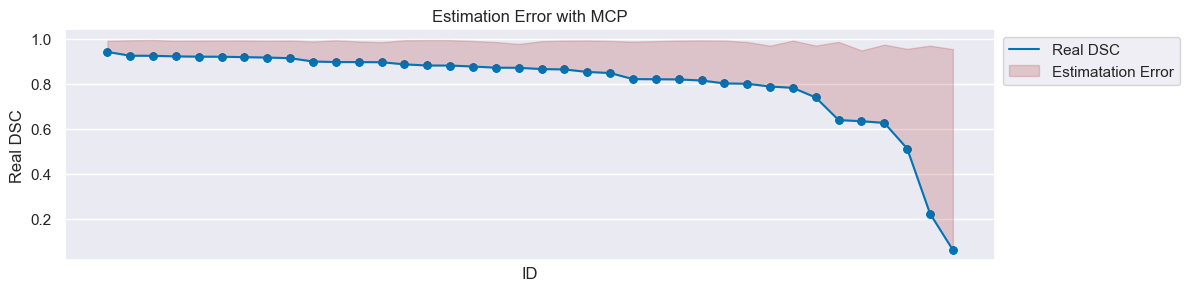

In [19]:
lineplot(estim_dsc_mcp, dsc_mcp, title = "Estimation Error with MCP")

## Plot the confidence map

In [59]:
def visual_two_case(conf_maps, imgs_toshow, lbls_toshow, preds_toshow, _real_dscs, _estim_dscs, title = 'The Visualization of MCP for Cases with High and Low DSC'):
    """Visualization of confidence score for two cases.
    
    Args:
        conf_maps: A list of confidence maps, of shape ``(H, W)``.
        imgs_toshow: A list of image, of shape ``(H, W)``.
        lbls_toshow: A list of label, of shape ``(H, W)``.
        preds_toshow: A list of prediction, of shape ``(H, W)``.
        _real_dscs: A list of real DSC (float).
        _estim_dscs: A list of esimtaed DSC (float).
        title: The given title to be shown.
    
    """

    from matplotlib.gridspec import GridSpec
    
    fig = plt.figure(figsize=(15, 8))
    gs = GridSpec(2, 3, width_ratios=[1, 1, 1.2])  # Adjust the ratios as needed
    
    cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True)
    
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    ax2 = plt.subplot(gs[2])
    ax3 = plt.subplot(gs[3])
    ax4 = plt.subplot(gs[4])
    ax5 = plt.subplot(gs[5])
    
    # Define colors for each class
    class_colors = ['', 'green', 'blue', 'red']  # Add more colors if you have more classes
    
    ax0.imshow(imgs_toshow[0], cmap='gray')
    ax0.set_title('Image Overlapped with Ground Truth', x=0.5, y=1.05)
    # Overlay the label map using class-specific colors
    for i in range(len(class_colors)):
        if i == 0:  # Skip label 0
            continue
        mask = lbls_toshow[0] == i
        label_map_rgb = np.zeros((*lbls_toshow[0].shape, 4))
        label_map_rgb[mask, :] = plt.cm.colors.to_rgba(class_colors[i])
    
        ax0.imshow(label_map_rgb, alpha=0.5)
    ax0.set_xticks([])
    ax0.set_yticks([])
    sns.heatmap(np.abs(preds_toshow[0] - lbls_toshow[0]), cmap=cmap, xticklabels=False, yticklabels=False, cbar=False, ax=ax1)
    ax1.set_title('Absolute Error between Prediction and Ground Truth', x=0.5, y=1.1)
    sns.heatmap(1 - conf_maps[0], cmap=cmap, xticklabels=False, yticklabels=False, cbar_kws={'format': ''}, ax=ax2)
    cbar = ax2.collections[0].colorbar
    ax2.set_title('Confidence Score', x=0.5, y=1.1)
    cbar.set_ticks([])
    cbar.ax.text(2.5, 0.04, 'min', ha='center', va='center')
    cbar.ax.text(2.5, 0.5, 'max', ha='center', va='center')
    #
    ax3.imshow(imgs_toshow[1], cmap='gray')
    ax3.set_title('Image Overlapped with Ground Truth', x=0.5, y=1.05)
    # Overlay the label map using class-specific colors
    for i in range(len(class_colors)):
        if i == 0:  # Skip label 0
            continue
        mask = lbls_toshow[1] == i
        label_map_rgb = np.zeros((*lbls_toshow[1].shape, 4))
        label_map_rgb[mask, :] = plt.cm.colors.to_rgba(class_colors[i])
    
        ax3.imshow(label_map_rgb, alpha=0.5)
    ax3.set_xticks([])
    ax3.set_yticks([])
    sns.heatmap(np.abs(preds_toshow[1] - lbls_toshow[1]), cmap=cmap, xticklabels=False, yticklabels=False, cbar=False, ax=ax4)
    ax4.set_title('Absolute Error between Prediction and Ground Truth', x=0.5, y=1.1)
    sns.heatmap(1 - conf_maps[1], cmap=cmap, xticklabels=False, yticklabels=False, cbar_kws={'format': ''}, ax=ax5)
    cbar = ax5.collections[0].colorbar
    ax5.set_title('Confidence Score', x=0.5, y=1.1)
    cbar.set_ticks([])
    cbar.ax.text(2.5, 0.04, 'min', ha='center', va='center')

    ax1.text(0.5, 1.05,  f'Real DSC is {_real_dscs[0]:.3f}', transform=ax1.transAxes, ha='center', va='center', fontsize=12)
    ax4.text(0.5, 1.05,  f'Real DSC is {_real_dscs[1]:.3f}', transform=ax4.transAxes, ha='center', va='center', fontsize=12)
    ax2.text(0.5, 1.05,  f'Estimated DSC is {_estim_dscs[0]:.3f}', transform=ax2.transAxes, ha='center', va='center', fontsize=12)
    ax5.text(0.5, 1.05,  f'Estimated DSC is {_estim_dscs[1]:.3f}', transform=ax5.transAxes, ha='center', va='center', fontsize=12)
    cbar.ax.text(2.5, 0.5, 'max', ha='center', va='center')
    
    fig.suptitle(title, fontsize=16, y=1)

In [60]:
dsc_sort = np.argsort(dsc_mcp)
imgs_toshow = [imgs_test[dsc_sort[-1]], imgs_test[dsc_sort[0]]]
lbls_toshow = [gt_test[dsc_sort[-1]], gt_test[dsc_sort[0]]]
preds_toshow = [np.argmax(logits_test[dsc_sort[-1]], axis=0), np.argmax(logits_test[dsc_sort[0]], axis=0)]
_real_dscs = [dsc_mcp[dsc_sort[-1]], dsc_mcp[dsc_sort[0]]]
#
conf_maps = [conf_mcp[dsc_sort[-1]], conf_mcp[dsc_sort[0]]]
_estim_dscs = [estim_dsc_mcp[dsc_sort[-1]], estim_dsc_mcp[dsc_sort[0]]]

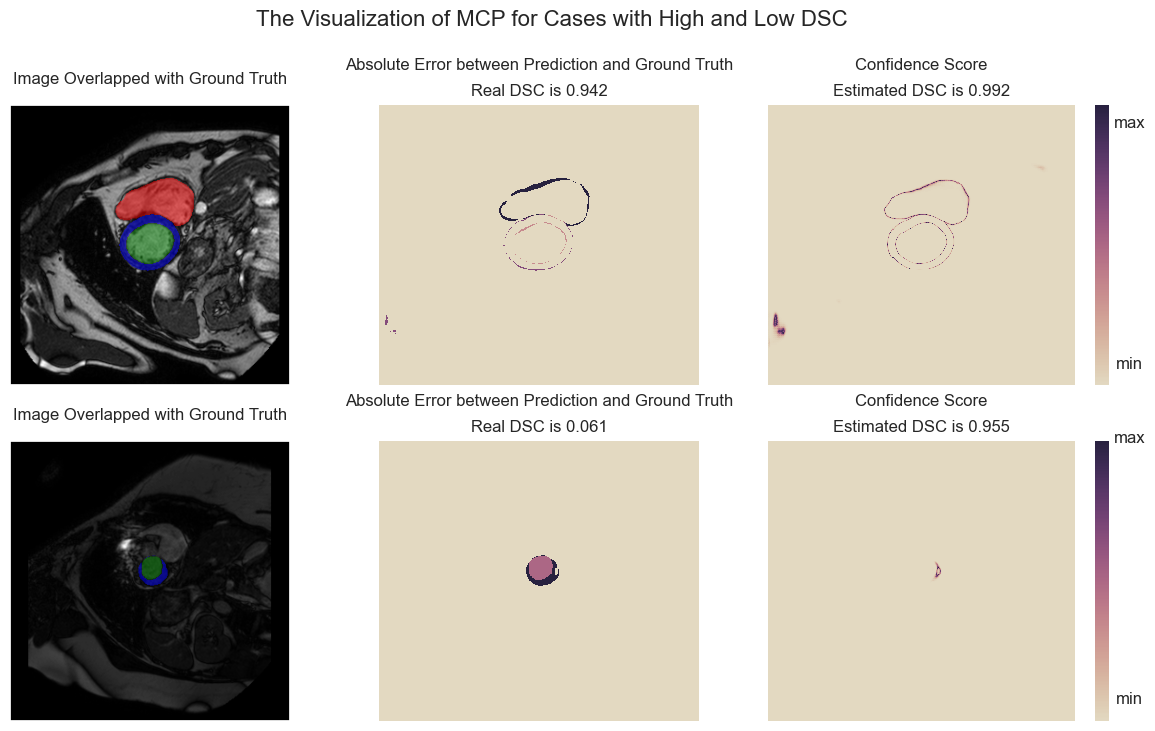

In [61]:
visual_two_case(conf_maps, imgs_toshow, lbls_toshow, preds_toshow, _real_dscs, _estim_dscs, title = 'The Visualization of MCP for Cases with High and Low DSC')